In [1]:
import numpy as np
import pandas as pd 
import heapq
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

In [2]:
np.random.seed(77)

### Limitations:
#### 1. No Abandments
#### 2. There is at least one field contractor available


### Initialization

In [3]:
class Event():
    def __init__(self, time, eventType, P , water_break= None, field_supervisor = None, field_contractor= None): 
        self.time = time # event time
        self.eventType = eventType # type of the event
        self.water_break = water_break
        self.field_supervisor = field_supervisor
        self.field_contractor = field_contractor
        self.P = P
        heapq.heappush(self.P, self) #add the event to the events list

    def __lt__(self,event2):
        return self.time < event2.time
    
class Water_Break(object):
    def __init__(self, occurred_time, i ):
        self.occurred_time = occurred_time
        

            
        self.id = i
        
        self.valve_closed = False # By field supervisor
        self.step2_got_handled = False # Pinpointing the Location of the Leak By field contractor
        self.step3_got_handled = False # Excavating for Leak Exposure and water pumping By field contractor
        self.step4_got_handled = False # Evaluating the Pipe Damage and Leak By field contractor
        self.step5_got_handled = False # Providing and Compacting Proper Backfill Material By field contractor
        self.step6_got_handled = False # Performing Proper Site Restoration By field contractor

class Field_Supervisor(object):
    def __init__(self, arrival_time, field_supervisor_curent_location, tools_status, i ):
        self.field_supervisor_curent_location = field_supervisor_curent_location
        self.arrival_time = arrival_time
        self.id = i 
        self.tools_status = tools_status
        self.is_occupied = False #(?)
        
class Field_Contractor(object):
    def __init__(self, arrival_time, field_contractor_curent_location, tools_status, i ):
        self.field_contractor_curent_location = field_contractor_curent_location
        self.arrival_time = arrival_time
        self.id = i 
        self.tools_status = tools_status
        self.is_truck_occupied = False #(?)
        
class Day_at_work(object):
    def __init__(self, chosen_sys_config, iter_id = 1):
        #Simulation params
        self.iter_id = iter_id
        self.curr_time = 0
        self.prev_time = 0
        self.P = []
        self.T = 10000
        self.L = []
        self.L_Time = 1000
        
        
        self.chosen_sys_config = chosen_sys_config
        
        self.water_break_counter = 0
        self.response_times = []
        self.poor_response_time_water_break_counter = 0
        self.stable_state_water_break_counter = 0
        self.truck_occupied = False

    

        #init the first break report
        Event(self.curr_time ,"leak or burst water pipe reported", self.P, water_break = Water_Break(self.curr_time,self.water_break_counter + 1)) 
        
        # init repairing
#         field_supervisor_curent_location = ["in_office", "is_in_his_way_to_field", "in_field", "is_in_his_way_to_office"]
#         tools_statuses = ["not_ok", "ok"]
#         field_supervisor_tools_status = {"T_key":tools_statuses[1]}
# #         occurred_time ,water_break = heapq.heappop(self.L)
#         x = np.random.uniform(0.5, 1)
#         Event(self.curr_time + x  ,"Pinpointing the Location of the Leak", self.P, water_break = Water_Break(self.curr_time,self.water_break_counter + 1) )
        #, field_supervisor_tools_status, 1),
        
        

### Measurements:

In [4]:
# N #Total number of breaks 
# PN #Total number of breaks with poor response time (Above 4hrs)
# -> N/NP

### Build simualtion

In [5]:
# for developing purposes params


def run_simulation(chosen_sys_config, n_iters= 1):
    field_supervisor_curent_location = ["in_office", "is_in_his_way_to_field", "in_field", "is_in_his_way_to_office"]
    # field_supervisors = {"A": field_supervisor_curent_location[0],
    #                      "B": field_supervisor_curent_location[0]}
    tools_statuses = ["not_ok", "ok"]
    field_supervisor_tools_status = {"T_key":tools_statuses[1]}
    
    from numpy.random import SeedSequence, default_rng

    ss = SeedSequence(7)

    # Spawn off 2 child SeedSequences to pass to child processes.
    child_seeds = ss.spawn(2)
    streams = [default_rng(s) for s in child_seeds]
    
    occurrences_stream = streams[0]
    repairment_stream = streams[1]
    
    total_response_times = np.array([])
    expected_response_time = [] #np.array([0]*100)
    poor_response_time_expectation = []
    
    for i in range(0, n_iters):

        
        sim = Day_at_work(chosen_sys_config = None, iter_id = i ) #, occurrences_stream = streams[0]
        
        
        while sim.curr_time < sim.T :
            
            
            sim.prev_time = sim.curr_time
            event = heapq.heappop(sim.P)
            sim.curr_time = event.time
            
                
            if event.eventType == "leak or burst water pipe reported" : 
                water_break = event.water_break
#                 occurrence_time = water_break.occurred_time
                sim.water_break_counter += 1
                
                heapq.heappush(sim.L, (event.water_break.occurred_time, water_break))
                
                
                if not sim.truck_occupied:
                    occurred_time ,_water_break = heapq.heappop(sim.L)
                    if np.random.uniform(0,1) <= 0.9:
                        x = np.random.uniform(5/60, 10/60)
                    else:
                        if not chosen_sys_config:
                            x = np.random.uniform(10/60, 2)
                        else:
                            x = np.random.uniform(10/60, 1)
#                     if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                         print(f"Water Break Wait Time: {x}: {sim.curr_time} - {sim.curr_time + x}")
                    Event(sim.curr_time + x , "Field Supervisor got called", sim.P, water_break=_water_break)
                else:
                    pass
#                     print("truck still occupied!")
                
                if sim.curr_time > sim.L_Time:
                    sim.stable_state_water_break_counter += 1

            #time for next occurrences
                if (sim.curr_time <= sim.T):
                    x = np.random.exponential(8860/300)#(8860/300) # 1/lambda
#                     x = np.random.exponential(300/8860)
                    Event(sim.curr_time + x ,"leak or burst water pipe reported", sim.P, Water_Break(sim.curr_time + x, sim.water_break_counter))
            
            elif event.eventType == "Field Supervisor got called" :
                sim.truck_occupied = True
#                 event.water_break.step1_got_handled = True
                x = np.random.uniform(15/60, 20/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Field Supervisor got called: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Pinpointing the Location of the Leak", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Pinpointing the Location of the Leak" :
#                 print("Location Pinpointed")
#                 print(len(sim.L))
                
#                 if (not sim.truck_occupied and not len(sim.L)):
#                 occurred_time ,water_break = heapq.heappop(sim.L)
                
                event.water_break.step2_got_handled = True
                x = np.random.uniform(10/60, 40/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Pinpointing the Location of the Leak: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Relevant valves closed", sim.P, water_break=event.water_break)
#                 else:
#                     print("**")
            
            elif event.eventType == "Relevant valves closed" :
#                 print("Relevant valves closed")
#                 sim.elevators[event.elevator].has_problem = False
                event.water_break.step2_got_handled = True
                x = np.random.uniform(20/60, 45/60)
#                 if i == 2000:
#                     print(f"Relevant valves closed: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Contractor got called", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Contractor got called" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Contractor got called")
                if np.random.uniform(0,1) <= 0.85:
                    x = np.random.uniform(0.5, 45/60)
                else:
                    if not chosen_sys_config:
                        x = np.random.uniform(45/60, 2.5)
                    else:
                        x = np.random.uniform(45/60, 1.5)
#                 x = np.random.uniform(0.5, 240/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Contractor in his way: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Water Pump", sim.P, water_break=event.water_break)
            
            elif event.eventType == "Water Pump" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Water Pump")
                event.water_break.step3_got_handled = True
                x = np.random.uniform(5/60, 10/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Water Pumping: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time  + x ,"Pipe Damage and Leak Evaluated", sim.P, water_break=event.water_break, field_supervisor = event.field_supervisor, field_contractor = event.field_contractor)
            
            elif event.eventType == "Pipe Damage and Leak Evaluated" :
#                 print("Pipe Damage and Leak Evaluated")
                event.water_break.step4_got_handled = True
                x = np.random.uniform(10/60, 15/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Pipe Damage and Leak Evaluating: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time  + x ,"Proper Backfill Material Provided", sim.P, water_break=event.water_break, field_supervisor = event.field_supervisor, field_contractor = event.field_contractor)
                
            elif event.eventType == "Proper Backfill Material Provided" :
#                 sim.elevators[event.elevator].has_problem = False
#                 print("Proper Backfill Material Provided")
                event.water_break.step5_got_handled = True
                if np.random.uniform(0,1) <= 0.8:
                    x = np.random.uniform(0.5, 1)
                else:
                    if not chosen_sys_config:
                        x = np.random.uniform(30/60, 2.5)
                    else:
                        x = np.random.uniform(30/60, 1.25)
#                 x = np.random.uniform(0.5, 240/60)
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Providing Proper Backfill Material: {x}: {sim.curr_time} - {sim.curr_time + x}")
                Event(sim.curr_time + x  ,"Service Ended", sim.P, water_break=event.water_break, field_supervisor = event.field_supervisor, field_contractor = event.field_contractor)
                
            elif event.eventType == "Service Ended" :
#                 if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                     print(f"Service Ended: {sim.curr_time - event.water_break.occurred_time}")
#                 event.water_break.step6_got_handled = True
                sim.truck_occupied = False
                event.water_break.step6_got_handled = True
        
            #Measurements
                if sim.curr_time > sim.L_Time:
                    sim.response_times.append(sim.curr_time - event.water_break.occurred_time)


                    if sim.curr_time - event.water_break.occurred_time > 4:
                        sim.poor_response_time_water_break_counter += 1
                
                if (len(sim.L) > 0):
#                     print(len(sim.L))
                    occurred_time ,water_break = heapq.heappop(sim.L)
#                     x = np.random.uniform(0.25, 0.45)
                    if np.random.uniform(0,1) <= 0.9:
                        x = np.random.uniform(5/60, 10/60)
                    else:
                        if not chosen_sys_config:
                            x = np.random.uniform(10/60, 2)
                        else:
                            x = np.random.uniform(10/60, 1)
#                     if sim.curr_time >= 2000 and sim.curr_time <= 3000:
#                         print(f"Water Break Wait Time: {x}: {sim.curr_time} - {sim.curr_time + x}")
                    Event(sim.curr_time + x  ,"Field Supervisor got called", sim.P, water_break=_water_break)
                else:
                    pass
#                     print("*")
                      
        

        sim_iters.append(sim)
        total_response_times = np.append(total_response_times, np.array(sim.response_times).reshape(-1,1))

        
        expected_response_time.append(np.array(sim.response_times).mean(dtype=np.float64))
        poor_response_time_expectation.append(sim.poor_response_time_water_break_counter/ sim.stable_state_water_break_counter)
#         print(expected_response_time)

    fig =plt.figure(figsize=((20,8)))
    ax1 = fig.add_subplot(111)
    ax1.set_title('Response time distribution')
    ax1.hist(total_response_times, bins=150, range=[0, 10], edgecolor='k')
    ax1.set(xlabel='Hours', ylabel='Counts')
    plt.tight_layout()
    plt.show()
    
#     print(poor_response_time_expectation)
    fig2, axs2 = plt.subplots(figsize=(16,4))
    axs2.scatter(x = range(n_iters), y = poor_response_time_expectation , label='poor_response_time_expectation', marker = 's')
    # Plot the average line
    y_mean = [np.mean(poor_response_time_expectation)]*n_iters
    axs2.plot(range(n_iters),y_mean, label='Mean', linestyle='--')
    axs2.set(xlabel='Simulation iters', ylabel='Expected poor_response_time')
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs2.text(0.05, 0.95, f"expected poor_response_time = {round(y_mean[0], 2)}" , transform=axs2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    axs2.set_title('Expected proportion of break repair with poor response time')
    plt.show()
   
    
#     print(np.array(visitors_affected_by_elevator_problem).mean())
    return(expected_response_time, poor_response_time_expectation)

### Run simualtion

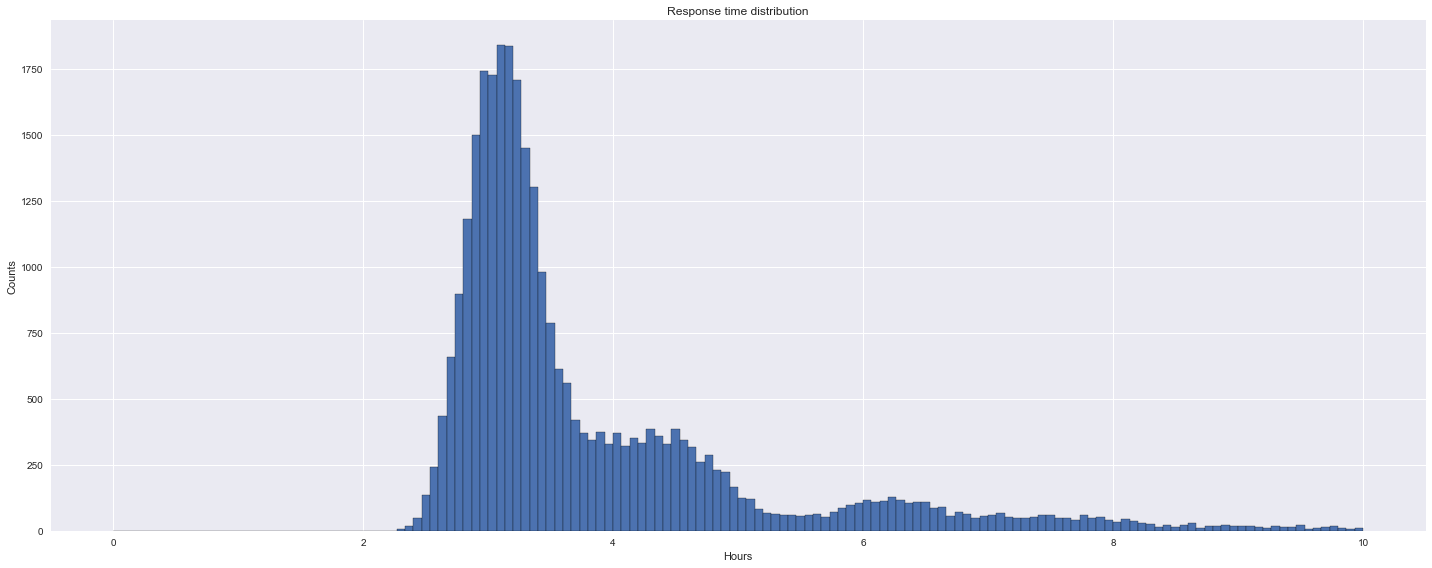

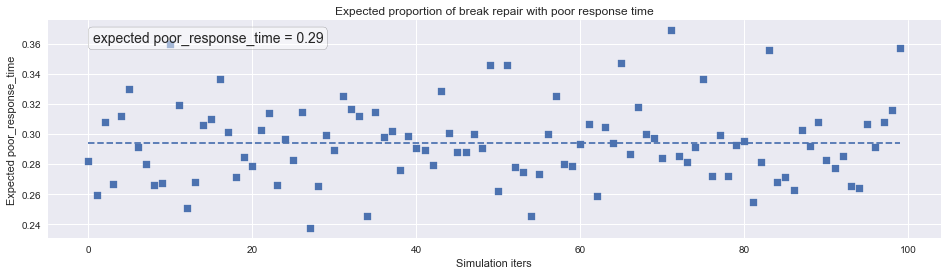

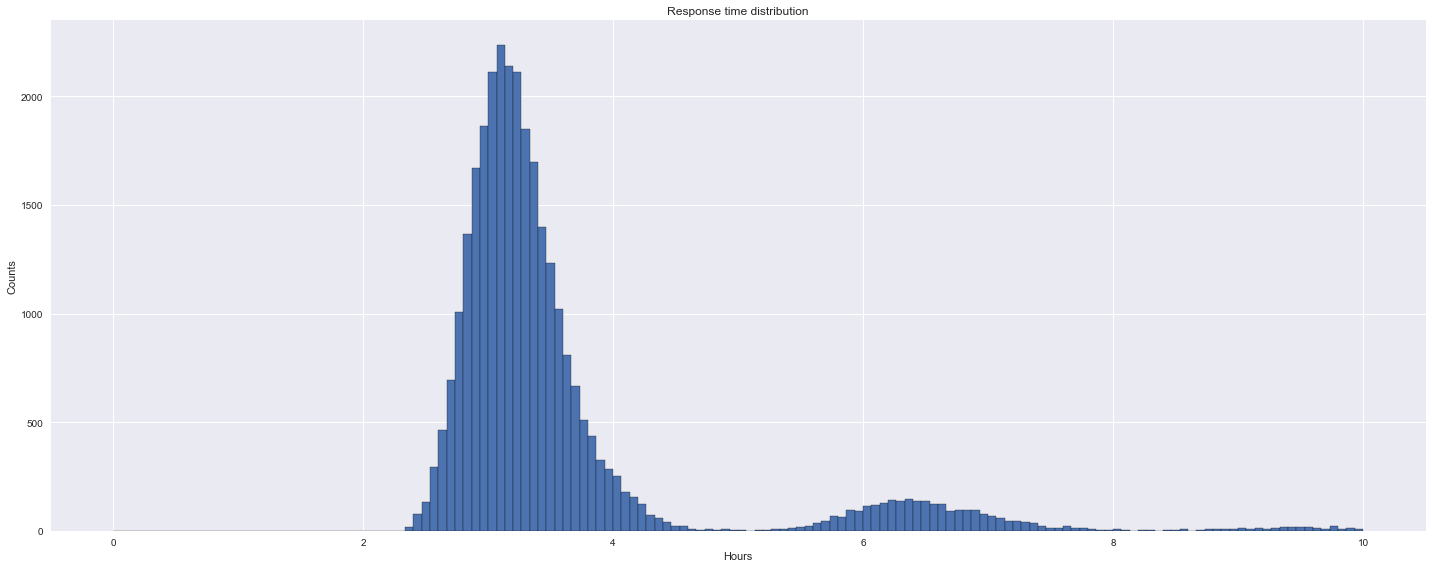

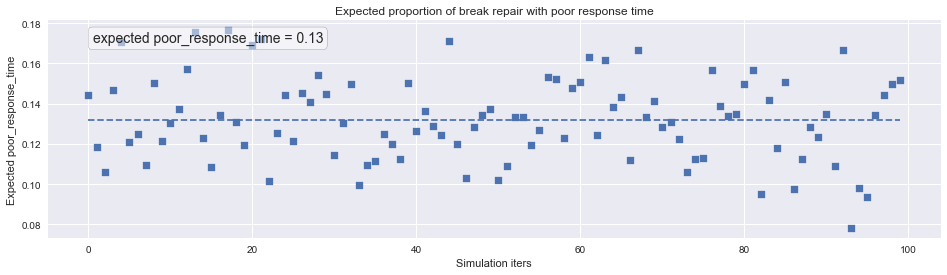

In [6]:
sim_iters = []
#System configurations; 0- Status quo    1- Our proposed solution
# sys_configurations = [0]
sys_configurations = [0,1]

config_measurements = {0: [], 
                       1: []
                       }

for config in sys_configurations:
    chosen_sys_config = config #sys_configurations[config]
#     days = []
    config_measurements[config] = run_simulation(config, n_iters= 100)
# config_measurements

### Ploting and visualization

In [36]:
config_measurements_df = pd.DataFrame(
                   columns=['states','expected_response_time', 'poor_response_time_expectation'])
config_measurements_df

,states,expected_response_time,poor_response_time_expectation


In [37]:
config_measurements_df['states'] = (["Current State"]*100)
config_measurements_df['expected_response_time'] = config_measurements[0][0]
config_measurements_df['poor_response_time_expectation'] = config_measurements[0][1]
config_measurements_df

,states,expected_response_time,poor_response_time_expectation
0,Current State,3.796705,0.282143
1,Current State,3.926030,0.259375
2,Current State,4.276167,0.307947
3,Current State,4.044304,0.266904
4,Current State,3.886752,0.311927
...,...,...,...
95,Current State,4.186576,0.306452
96,Current State,4.042500,0.291525
97,Current State,4.070292,0.307958
98,Current State,4.063251,0.315789


In [38]:
_sim_iters = list(range(100))
config_measurements_df['sim_iters'] = _sim_iters
config_measurements_df

,states,expected_response_time,poor_response_time_expectation,sim_iters
0,Current State,3.796705,0.282143,0
1,Current State,3.926030,0.259375,1
2,Current State,4.276167,0.307947,2
3,Current State,4.044304,0.266904,3
4,Current State,3.886752,0.311927,4
...,...,...,...,...
95,Current State,4.186576,0.306452,95
96,Current State,4.042500,0.291525,96
97,Current State,4.070292,0.307958,97
98,Current State,4.063251,0.315789,98


In [39]:
config_measurements_df2 = pd.DataFrame(
                   columns=['states','expected_response_time', 'poor_response_time_expectation'])
# config_measurements_df2
config_measurements_df2['states'] = (["Our proposed solution"]*100)
config_measurements_df2['expected_response_time'] = config_measurements[1][0]
config_measurements_df2['poor_response_time_expectation'] = config_measurements[1][1]
config_measurements_df2

,states,expected_response_time,poor_response_time_expectation
0,Our proposed solution,3.674890,0.144231
1,Our proposed solution,3.616091,0.118243
2,Our proposed solution,3.534415,0.105960
3,Our proposed solution,3.588153,0.146875
4,Our proposed solution,3.750935,0.170807
...,...,...,...
95,Our proposed solution,3.561422,0.093750
96,Our proposed solution,3.602088,0.134276
97,Our proposed solution,3.544036,0.144231
98,Our proposed solution,3.661725,0.149682


In [40]:
_sim_iters = list(range(100))
config_measurements_df2['sim_iters'] = _sim_iters
config_measurements_df2

,states,expected_response_time,poor_response_time_expectation,sim_iters
0,Our proposed solution,3.674890,0.144231,0
1,Our proposed solution,3.616091,0.118243,1
2,Our proposed solution,3.534415,0.105960,2
3,Our proposed solution,3.588153,0.146875,3
4,Our proposed solution,3.750935,0.170807,4
...,...,...,...,...
95,Our proposed solution,3.561422,0.093750,95
96,Our proposed solution,3.602088,0.134276,96
97,Our proposed solution,3.544036,0.144231,97
98,Our proposed solution,3.661725,0.149682,98


In [41]:
config_measurements_df = config_measurements_df.append(config_measurements_df2, ignore_index=True)

In [42]:
config_measurements_df

,states,expected_response_time,poor_response_time_expectation,sim_iters
0,Current State,3.796705,0.282143,0
1,Current State,3.926030,0.259375,1
2,Current State,4.276167,0.307947,2
3,Current State,4.044304,0.266904,3
4,Current State,3.886752,0.311927,4
...,...,...,...,...
195,Our proposed solution,3.561422,0.093750,95
196,Our proposed solution,3.602088,0.134276,96
197,Our proposed solution,3.544036,0.144231,97
198,Our proposed solution,3.661725,0.149682,98


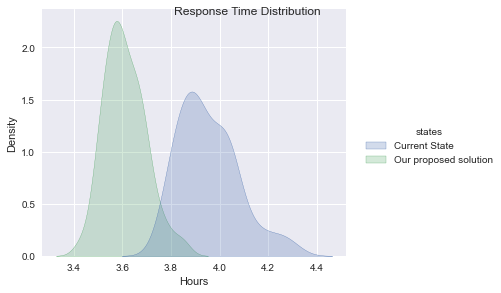

In [52]:
g = sns.displot(config_measurements_df, x="expected_response_time", hue="states", kind="kde", fill=True)
g.fig.suptitle('Response Time Distribution')
g.fig.set_figwidth(7)
g.fig.set_figheight(4)
plt.xlabel("Hours")
# plt.ylabel("Values")
plt.show()

In [47]:
mean_config_measurements_df = config_measurements_df.groupby('states').mean()
y_mean = mean_config_measurements_df.poor_response_time_expectation.values

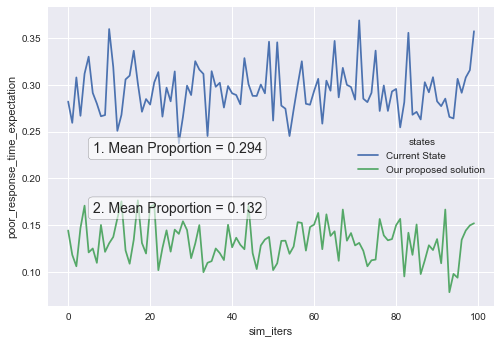

In [50]:
axs1 = sns.lineplot(x = 'sim_iters' , y="poor_response_time_expectation",
             hue="states",
             data=config_measurements_df)
# y_mean = config_measurements_df.groupby(states)
props = dict(boxstyle='round', facecolor='white', alpha=0.6)
axs1.text(0.1, 0.55, f"1. Mean Proportion = {round(y_mean[0], 3)}" , transform=axs1.transAxes, fontsize=14,verticalalignment='top', bbox=props)
axs1.text(0.1, 0.35, f"2. Mean Proportion = {round(y_mean[1], 3)}" , transform=axs1.transAxes, fontsize=14,verticalalignment='top', bbox=props)

plt.show()

In [49]:
for idx in range(len(sim_iters)):
    print(np.array(sim_iters[idx].response_times).mean())

3.7967046081018085
3.926029650719344
4.276167307817483
4.044304129597013
3.8867523384507603
3.935342639927495
3.933359811925766
3.7925047241235568
3.983943944627592
3.821733127519589
4.030059845257344
3.939176836779315
3.815761186373459
3.819473928064132
4.151292496014043
4.062456699325483
4.125233939958848
3.8333614962686693
3.866676941656457
3.97989641379884
3.998199395647592
4.015316540165617
4.07869119643884
3.9061694580566346
4.015699370944942
3.880904574286623
4.028749107528156
3.7745941835035497
3.8447201268476188
3.8663483428911807
3.971876023380145
4.035325607043651
4.094105344522048
3.9097696734210587
3.793091862478685
3.8749776679055667
3.8479932948385476
4.035670679042528
3.882914588223976
3.9243949775866978
3.972382175591614
3.8681642585063867
3.9144506177092153
4.09140361136773
4.024143479430865
3.918926360175328
4.011203201449144
4.030608151409401
3.881943411465411
4.264092373078114
3.7976536181941145
4.3158466400639135
4.0053509846861175
3.8550431814082153
3.74554488972

In [ ]:
print(sim_iters)